# Prediction Questionnaire

My goal in this questionnaire is to develop a predictive model of MLB
hitter’s OBP in the 2021 season using historical data from past seasons.

## Load packages

In [1]:
from datetime import datetime, timezone, timedelta
import httpimport
import numpy as np
import pandas as pd
import plotnine as pn
from pybaseball import (
    playerid_reverse_lookup,
    statcast_batter_expected_stats,
    statcast_batter_exitvelo_barrels
)
import xgboost as xgb

with httpimport.github_repo("dmolitor", "xgboost-gridsearch", ref="main"):
    from xgb_gridsearch.grid_search import GridSearch

## Import data

First step is to import the data.

In [2]:
file_id = "1sxUa7GJXJNgJ0qcdcbo9Ovbb8jrtTjtT"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
obp_data = pd.read_csv(url)

## Prep data for modeling

Next, let’s collect some additional data for the years 2016-2020 that
could potentially improve our predictive capactiy for OBP in 2021. I
will use Statcast data for all players where available; this data will
include the following:

-   Balls in play
-   Batting average; Expected BA; Difference between the two
-   Slugging percentage; Expected slugging; Difference between the two
-   Weighted on-base average; Expected WOBA; Difference between the two
-   Percentage of hits with a launch-angle sweet spot
-   Average batted-ball distance
-   Average batted-ball launch angle
-   Average batted-ball exit velocity
-   Total number of barrels
-   Barrels per plate appearance
-   Barrel percentage (percentage of batted balls)
-   Average batted-ball exit velocity for hardest 50% of batted balls
-   Fly ball + line-drive rate
-   Ground ball rate
-   Max batted ball distance
-   Max batted ball speed

First, I will create a function to retrieve the data sets containing
these values.

In [3]:
def statcast_data(source: str) -> pd.DataFrame:
    if source == "expected":
        fn = statcast_batter_expected_stats
    else:
        fn = statcast_batter_exitvelo_barrels
    stats = []
    for year in range(2016, 2021):
        stats.append(fn(year, 1).assign(year = year))
    stats_df = (
        pd
        .concat(stats, axis=0)
        .reset_index(drop=True)
        .assign(name = lambda df: df["last_name, first_name"])
        .drop(columns="last_name, first_name")
        .pivot_table(index=["player_id", "name"], columns="year", aggfunc="first")
    )
    stats_df.columns = [f"{col[0]}_{str(col[1])[-2:]}" for col in stats_df.columns]
    stats_df.reset_index(drop=False, inplace=True)
    return stats_df

Now, I’ll retrieve this data from the Statcast expected batting stats
and exit velocity datasets, respectively.

In [4]:
expected_stats = statcast_data("expected").drop(columns=[f"pa_{y}" for y in range(16, 21)])
exit_velo = statcast_data("exitvelo").drop(columns=[f"attempts_{y}" for y in range(16, 21)])

In order to merge this data to the original data, I will need to create
a crosswalk from FanGraphs player IDs to MLB IDs.

In [5]:
player_id_xwalk = (
    playerid_reverse_lookup(obp_data["playerid"], key_type="fangraphs")
    [["key_mlbam", "key_fangraphs"]]
)

Now, I’ll merge all this data to the original dataset.

In [6]:
obp_data = (
    pd
    .merge(
        obp_data,
        player_id_xwalk,
        left_on="playerid",
        right_on="key_fangraphs",
        how="left"
    )
    .merge(
        expected_stats.drop(columns="name"),
        left_on="key_mlbam",
        right_on="player_id",
        how="left"
    )
    .drop(columns="player_id")
    .merge(
        exit_velo.drop(columns="name"),
        left_on="key_mlbam",
        right_on="player_id",
        how="left"
    )
    .assign(
        age = lambda df: (
            df["birth_date"]
            .apply(lambda x: (pd.to_datetime("2021-03-31") - pd.to_datetime(x)).days/365)
        )
    )
    .drop(columns=[
        "Name", 
        "playerid", 
        "birth_date",
        "PA_21",
        "key_mlbam",
        "key_fangraphs",
        "player_id"
    ])
)

Now, I have a rich set of potential predictors. However, it’s important
to note that a lot of data is missing, especially for predictors from
2016-2017. This is because a lot of the active players in 2021 were not
active during that time. In order to address this, I have a couple
options. I can either use some imputation method for missing values or I
can use a predictive algorithm that can handle missing values. I choose
the latter!

## Build predictive model

I will use the XGBoost algorithm to train my predictive model for OBP. I
like XGBoost for the following reasons:

-   Ensemble models tend to be more robust to overfitting than
    non-ensemble models.
-   XGBoost is a tree-based algorithm, allowing it to detect and model
    non-linear relationships between the predictors.
-   XGBoost handles missing data by default, which is important in this
    instance.
-   Empirically, XGBoost often performs as well/better than many other
    algorithms.

XGBoost has a variety of hyper-parameters that I will find the optimal
combination of using grid-search. Also, in order to find the optimal
number of iterations in my XGBoost model (to avoid overfitting) I will
train each model using early-stoppage with 10-fold cross-validation to
assess model performance. While I can evaluate the optimal model’s
performance by its average error on cross-validation hold-out sets, I
will also set aside a small subset (10%) of the data to validate its
performance.

**Note:** The code I use to do this is a small module I built on top of
XGBoost specifically designed to streamline grid-search with
early-stoppage via cross-validation. The code for this module is [on
Github](https://github.com/dmolitor/xgboost-gridsearch).

First, I will split the data into training (90%) and testing (10%).

In [7]:
np.random.seed(111)
train_idx = np.sort(
    np.random.choice(
        range(len(obp_data)),
        np.floor(0.9 * len(obp_data)).astype(int),
        replace=False
    )
)

# Split data
train = obp_data.iloc[train_idx].reset_index(drop=True)
test = obp_data.drop(train_idx, axis=0).reset_index(drop=True)

dtrain = xgb.DMatrix(
    data = train.drop("OBP_21", axis=1),
    label=train[["OBP_21"]],
    enable_categorical=True
)
dtest = xgb.DMatrix(data = test.drop("OBP_21", axis=1))

### Train model

Now I will construct a grid of all the hyper-parameter combinations I
want to optimize over. Each model will be evaluated by it’s average Root
Mean Squared Error (RMSE) on cross-validation hold-out folds, and the
optimal model will be the set of hyper-parameters that minimizes this
value.

In [8]:
params = {
    "objective": ["reg:squarederror"],
    "learning_rate": [0.1, 0.3],
    "min_split_loss": [0, 1, 3],
    "max_depth": [3, 6, 9],
    "min_child_weight": [0.5, 1, 3],
    "reg_lambda": [0.5, 1, 3],
    "reg_alpha": [0, 0.5]
}

# Train the model
grid_search = GridSearch(
    param_grid=params,
    dtrain=dtrain,
    num_boost_round=1000,
    nfold=10,
    shuffle=True,
    metrics=["rmse"],
    early_stopping_rounds=10,
    verbose_eval=False,
    seed=123
)
grid_search.fit(verbose=False, minimize_cv_metric=True, refit=True)

### Evaluate performance

As noted above, I will evaluate the optimal model’s performance by
checking its mean RMSE across 10 cross-validation hold-out folds, as
well as its performance on the 10% hold-out set of data.

In [9]:
cv_rmse, cv_rmse_std = (
    grid_search.
    model_metrics.iloc[grid_search.best_idx]
    [["test-rmse-mean", "test-rmse-std"]]
)
test_rmse = np.sqrt(
    np.mean(
        (test["OBP_21"] - grid_search.best_model.predict(dtest))**2
    )
)

print(
    f"  CV RMSE: {round(cv_rmse, 3)}; Std. Dev.: {round(cv_rmse_std, 3)}\n"
    + f"Test RMSE: {round(test_rmse, 3)}"
)

  CV RMSE: 0.047; Std. Dev.: 0.005
Test RMSE: 0.044

The RMSE of my optimal model is approximately 4.7 percentage points,
which is quite small. The estimated error rate from cross-validation
aligns closely with estimated error on the hold-out test set.

## Conclusion

Couple interesting notes:

-   The model didn’t really gain any predictive boost from adding all
    the Statcast data to the original dataset. This would indicate (and
    aligns with my prior belief) that OBP is a fairly noise quantity to
    predict and you can’t necessarily solve it just by throwing a bunch
    of data at it.
-   Just for fun, we can take a look graphically at how bad our
    predictions on the test set are compared to a perfectly predictive
    model. While our model does okay for quite a few values, it also
    fails miserably on quite a few values which kind of confirms my
    point above.

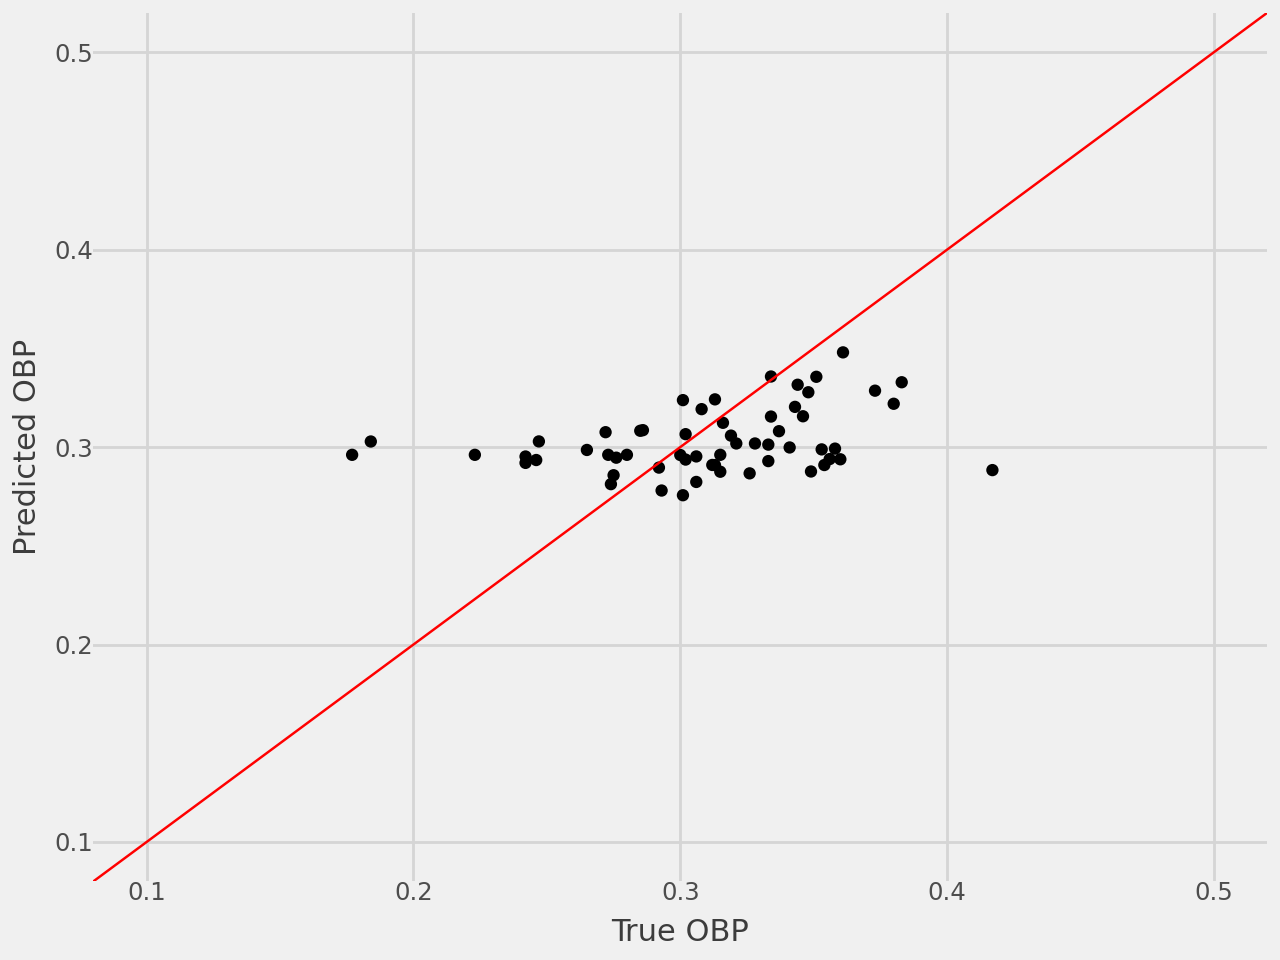

In [10]:
pred_error_df = pd.DataFrame({
    "obp_21": test["OBP_21"],
    "obp_21_pred": grid_search.best_model.predict(dtest)
})
(
    pn.ggplot(pred_error_df, pn.aes(x="obp_21", y="obp_21_pred"))
    + pn.geom_point()
    + pn.geom_abline(slope=1, intercept=0, color="red")
    + pn.scale_y_continuous(limits=(0.1, 0.5))
    + pn.scale_x_continuous(limits=(0.1, 0.5))
    + pn.theme_538()
    + pn.labs(x="True OBP", y="Predicted OBP")
)

## Packages and versions used

Python 3.11.8

In [11]:
httpimport==1.4.0
jupyter==1.1.1
numpy==2.1.1
pandas==2.2.2
plotnine==0.13.6
pybaseball==2.2.7
xgboost==2.1.1